# Funathon 2023 - Sujet 3 : Habitudes alimentaires à partir des données INCA

Site : https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/

Documentation : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

Pour en savoir plus sur le clustering : https://pythonds.linogaliana.fr/clustering/

Partie clustering

## Imports

### Packages

In [1]:
import logging
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [2]:
logging.getLogger('matplotlib.font_manager').disabled = True
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

### Données

#### Tables relatives aux habitudes des individus ou des ménages

##### Table HABITUDES_INDIV (page 27)

Cette table contient les données des questionnaires auto-administrés relatifs aux volets « Habitudes alimentaires » et « Origine des aliments ».

Elle regroupe les informations suivantes : lieux et occasions de consommation, consommations hors-foyer et entre les repas, préférences alimentaires, présence de
sel/beurre/sauce sur la table au moment des repas, lecture des étiquettes, sources d’informations en alimentation, consommation de denrées animales crues et des
croûtes de fromage, préparation des fruits et légumes crus, spécificités de l’alimentation des enfants de 0 à 35 mois (ex : allaitement (exclusif ou partiel), type de laits consommés, diversification alimentaire, matériaux des biberons et des tétines, préparation, stockage et conservation des biberons de lait, mode de chauffage des laits et contenants utilisés), autoconsommation et utilisation de produits phytosanitaires au potager, consommation d’aliments issus de l’agriculture biologique et cuisson des aliments au barbecue.

In [3]:
habitudes_indiv = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/099351b9-e32e-4e38-8f23-dec21fd07c71",
                            sep=";"
                            ).infer_objects()
print(f'{len(habitudes_indiv)} lignes et {len(habitudes_indiv.columns)} colonnes')
habitudes_indiv.head(3)

4372 lignes et 389 colonnes


,POPULATION,NOIND,periode_reference,repasenfantmidi_vous,repasenfantmidi_am,repasenfantmidi_creche,repasenfantmidi_parent,repasenfantmidi_autre,repasenfantmidi_autre_libelle,repasenfant_freq,conso_bebe_sein,lait_plussouvent,lait_plusvt_li_autr_anim_libelle,lait_plusvt_pi_autre_veg_libelle,lait_plusvt_boisson_veg_libelle,lait_plusvt_autre_anim_libelle,lait_plusvt_autre_libelle,lait_occ_laitmaternel,lait_occ_lait_1e_age,lait_occ_lait_2e_age,lait_occ_lait_croissance,lait_occ_li_autre_anim,lait_occ_li_autre_anim_libelle,lait_occ_li1e_age_protsoja,lait_occ_li2e_age_protsoja,lait_occ_soja_croissance,lait_occ_li1e_age_protriz,lait_occ_li2e_age_protriz,lait_occ_riz_croissance,lait_occ_pi_autre_veg,lait_occ_pi_autre_veg_libelle,lait_occ_boisson_lait_bebe,lait_occ_lait_regime_infantile,lait_occ_lait_vache,lait_occ_boisson_soja,lait_occ_boisson_veg,lait_occ_boisson_veg_libelle,lait_occ_autre_anim,lait_occ_autre_anim_libelle,lait_occ_autre,lait_occ_autre_libelle,lait_occ_aucun,lait_occ_nsp,etablissement_scolaire,lieu_repas_midi,lieu_repas_midi_autre_libelle,cantine_freq,cantine_jms_persfoyer,cantine_jms_veutpas,cantine_jms_probsante,cantine_jms_repaspasequilibre,cantine_jms_repaspasqualite,cantine_jms_repaschers,cantine_jms_ecoleproche,cantine_jms_paspropose,cantine_jms_pasaime,cantine_jms_autre_raison,cantine_jms_autre_raison_libelle,cantine_jms_nsp,collation_freq,collation_aliment1,collation_aliment2,collation_aliment3,collation_aliment4,collation_matin_freq,collation_matin_ecole_freq,collation_matin_pasecole_freq,collation_matin_aliment1,collation_matin_aliment2,collation_matin_aliment3,collation_matin_aliment4,distributeur_freq,distributeur_biscuits_sales,distributeur_biscuits_sucres,distributeur_barres_choco,distributeur_confiseries,distributeur_fruits_frais,distributeur_jus_de_fruits,distributeur_boissons_energ,distributeur_sodas,distributeur_eaux,distributeur_autre,distributeur_autre_libelle,distributeur_nsp,restaurationrapide_freq,aime_legumes,aime_viande,aime_fruits,aime_glaces,aime_fromage,aime_poisson,aime_soda,aime_lait,aime_yaourts,aime_jus_de_fruits,table_beurre,table_creme_fraiche,table_huile_olive,table_vinaigrette,table_mayonnaise,table_ketchup,table_sauce_soja,table_sel,etiquette_freq,etiquette_ingredients,etiquette_contenu_nutri,etiquette_portions,etiquette_message_nutri,etiquette_effets_benefiques,source_medecins,source_personnels_pharma,source_publicite,source_emissions_info,source_journaux,source_livres,source_professeurs,source_famille,source_amis,source_internet,source_emballages,source_autre,source_autre_libelle,conso_lardons_crus,conso_saucisses_crues,conso_viande_boeuf_crue,conso_viande_cheval_crue,conso_viande_porc_crue,conso_viande_volaille_crue,conso_poisson_cru,conso_mollusques_crus,conso_oeufs_crus,conso_croute_fleurie,conso_croute_lavee,conso_pate_pressee_non_cuite,conso_pate_pressee_cuite,conso_pate_persillee,pomme_crue_lave,pomme_crue_essuie,pomme_crue_epluche,pomme_crue_rien,pomme_crue_mange_pas,peche_crue_lave,peche_crue_essuie,peche_crue_epluche,peche_crue_rien,peche_crue_mange_pas,raisin_cru_lave,raisin_cru_essuie,raisin_cru_epluche,raisin_cru_rien,raisin_cru_mange_pas,fraise_crue_lave,fraise_crue_essuie,fraise_crue_epluche,fraise_crue_rien,fraise_crue_mange_pas,tomate_crue_lave,tomate_crue_essuie,tomate_crue_epluche,tomate_crue_rien,tomate_crue_mange_pas,champignon_cru_lave,champignon_cru_essuie,champignon_cru_epluche,champignon_cru_rien,champignon_cru_mange_pas,salade_crue_lave,salade_crue_essuie,salade_crue_epluche,salade_crue_rien,salade_crue_mange_pas,concombre_cru_lave,concombre_cru_essuie,concombre_cru_epluche,concombre_cru_rien,concombre_cru_mange_pas,utilisation_bib,bib_plastique,bib_verre,bib_nsp,sterilisation_bib,sterilisation_bib_libelle,tetine_caoutchouc,tetine_silicone,tetine_nsp,sterilisation_tetine,sterilisation_tetine_libelle,bib_lm,bib_li,bib_lc,bib_bl,bib_ppl,bib_eau,bib_jus,bib_autre,bib_autre_libelle,stockage_bib_lm,delai_conso_bib_lm,prepa_bib_li,conserv_eau,conserv_eau_libelle,

##### Table ACTPHYS_SEDENT (page 48)

Cette table contient les données des questionnaires auto-administrés (pour les adultes 18-79 ans) et face-à-face (pour les enfants 3-17 ans) relatifs au volet
« Sédentarité, activité physique et loisirs ». Il n’y a pas de données relatives à cette thématique pour les enfants de 0-35 mois.

Elle regroupe les informations suivantes : mode de transport du trajet domicile-travail, temps passé devant les écrans (télévision, jeux vidéo, ordinateur) pendant la semaine et le week-end, pratique et fréquence d’une activité physique (y compris dans le cadre scolaire), type d’activité physique pratiquée, niveau d’activité physique, niveau de sédentarité et profils d’activité physique.

In [4]:
actphys_sedent = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e9a34b81-2105-4d82-a023-c14947fb2b2c",
                            sep=";"
                            ).infer_objects()
print(f'{len(actphys_sedent)} lignes et {len(actphys_sedent.columns)} colonnes')
actphys_sedent.head(3)

4725 lignes et 93 colonnes


,POPULATION,NOIND,transport_personnel,transport_ecole,tv_score,tv_duree,jvideo_score,jvideo_duree,ordi_score,ordi_duree,jeux_pleinair_nbjours,enfant_actif,eps_ouinon,eps_nbjours,eps_duree,club_nbjours,club_nb,activite_musculation_nbjours,activite_moderee_nbjours,activite_intense_nbjours,escalier_score,emploi_4sem,travail_freq_semaine,travail_duree,travail_score,transport_voiture_score,transport_public_score,transport_velo_score,transport_pied_score,transport_score,activite_balayer_score,activite_nettoyer_score,activite_aspirateur_score,activite_repasser_score,activite_vaisselle_score,activite_lessive_score,activite_jardiner_score,activite_tondre_score,activite_arroser_score,activite_becher_score,activite_bricoler_score,activite_marche_score,activite_piscine_score,activite_velo_score,activite_roller_score,activite_danse_salon_score,activite_bowling_score,activite_billard_score,activite_peche_score,activite_chasse_score,activite_loisirs_assis_score,activite_loisirs_debout_score,activite_randonnee_score,activite_jogging_score,activite_natation_score,activite_yoga_score,activite_rameur_score,activite_aerobic_score,activite_danse_moderne_score,activite_cyclisme_score,activite_tennis_score,activite_boxe_score,activite_escrime_score,activite_haltere_score,activite_athletisme_score,activite_ski_score,activite_voile_score,activite_canoe_score,activite_equitation_score,activite_golf_score,activite_tir_score,activite_moto_score,activite_musique_score,activite_ping_pong_score,activite_gym_score,activite_escalade_score,activite_alpinisme_score,activite_foot_score,activite_rugby_score,activite_basket_score,activite_hand_score,activite_volley_score,activite_hockey_score,activite_domloissport_duree,activite_domloissport_score,activite_moderee_score,activite_intense_score,activite_total_duree,activite_total_score,nap,profil_activite,sedentarite,sedentarite_duree
0,Pop1 Individu,120100401,NaN,1.0,NaN,1.642857,NaN,0.000000,NaN,0.000000,2.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,NaN
1,Pop1 Individu,120100501,NaN,1.0,NaN,0.821429,NaN,0.964286,NaN,0.571429,NaN,NaN,NaN,2.0,3.0,NaN,2.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,NaN
2,Pop1 Individu,120100601,NaN,3.0,NaN,1.142857,NaN,0.000000,NaN,0.571429,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,NaN


##### Table FPQ (page 52)

Cette table contient les données des questionnaires auto-administrés relatifs au volet « Fréquentiel alimentaire ». Ce questionnaire n’était proposé qu’aux enfants ayant démarré la diversification alimentaire (ainsi 30 enfants de 0-35 mois n’y ont pas répondu).

Elle regroupe les informations suivantes : consommation (oui/non) pour environ une soixantaine d’aliments ou groupes d’aliments, puis si oui, fréquence de
consommation.

In [5]:
fpq = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/32e79499-9897-423b-acd6-143121340f86",
                            sep=";"
                            ).infer_objects()
print(f'{len(fpq)} lignes et {len(fpq.columns)} colonnes')
fpq.head(3)

4339 lignes et 384 colonnes


,POPULATION,NOIND,PC_pain_ON,PC_pain_freq_M,PC_paincomplet_ON,PC_paincomplet_freq_M,PC_cereales_pdj_complet_ON,PC_cereales_pdj_complet_freq_M,PC_cereales_pdj_autre_ON,PC_cereales_pdj_autre_freq_M,RP_riz_tot_ON,RP_riz_tot_freq_M,RP_riz_complet_ON,RP_riz_complet_freq_M,RP_pdt_tot_ON,RP_pdt_tot_freq_M,RP_pdt_frites_ON,RP_pdt_frites_freq_M,RP_legumeracine_ON,RP_legumeracine_freq_M,RP_tubercule_ON,RP_tubercule_freq_M,LEG_tot_ON,LEG_tot_freq_M,LEG_salade_ON,LEG_salade_freq_M,LEG_bettera_tot_ON,LEG_bettera_tot_freq_M,LEG_bettera_carot_ON,LEG_bettera_carot_freq_M,LEG_concombre_ON,LEG_concombre_freq_M,LEG_concombre_printété_ON,LEG_concombre_printété_freq_M,LEG_concombre_automhiv_ON,LEG_concombre_automhiv_freq_M,LEG_tomate_tot_ON,LEG_tomate_tot_freq_M,LEG_tomate_tot_printété_ON,LEG_tomate_tot_printété_freq_M,LEG_tomate_tot_automhiv_ON,LEG_tomate_tot_automhiv_freq_M,LEG_tomate_seul_ON,LEG_tomate_seul_freq_M,LEG_tomate_seul_printété_ON,LEG_tomate_seul_printété_freq_M,LEG_tomate_seul_automhiv_ON,LEG_tomate_seul_automhiv_freq_M,LEG_chou_ON,LEG_chou_freq_M,LEG_artichaut_ON,LEG_artichaut_freq_M,LEG_champignon_ON,LEG_champignon_freq_M,LEG_oignon_ON,LEG_oignon_freq_M,LEG_legsecs_ON,LEG_legsecs_freq_M,LEG_soupe_ON,LEG_soupe_freq_M,LEG_soupe_automhiv_ON,LEG_soupe_automhiv_freq_M,LEG_soupe_printété_ON,LEG_soupe_printété_freq_M,LEG_saucetomate_ON,LEG_saucetomate_freq_M,VC_tot_ON,VC_tot_freq_M,VC_boeuf_ON,VC_boeuf_freq_M,VC_agneau_ON,VC_agneau_freq_M,VC_poulet_ON,VC_poulet_freq_M,VC_lapin_ON,VC_lapin_freq_M,VC_porc_ON,VC_porc_freq_M,VC_saucisson_ON,VC_saucisson_freq_M,VC_pate_foie_ON,VC_pate_foie_freq_M,VC_pate_autre_ON,VC_pate_autre_freq_M,VC_foie_ON,VC_foie_freq_M,PPM_tot_ON,PPM_tot_freq_M,PPM_poissgras_tot_ON,PPM_poissgras_tot_freq_M,PPM_poissgras_thon_ON,PPM_poissgras_thon_freq_M,PPM_poissonautre_ON,PPM_poissonautre_freq_M,PPM_surimi_ON,PPM_surimi_freq_M,PPM_crustace_ON,PPM_crustace_freq_M,PPM_mollusque_ON,PPM_mollusque_freq_M,OE_oeuf_ON,OE_oeuf_freq_M,OE_quiche_ON,OE_quiche_freq_M,SOJ_soja_ON,SOJ_soja_freq_M,PL_lait_ON,PL_lait_freq_M,PL_fromage_tot_ON,PL_fromage_tot_freq_M,PL_fromage_laitcru_ON,PL_fromage_laitcru_freq_M,PL_yaourtentremet_ON,PL_yaourtentremet_freq_M,PL_yaourt_tot_ON,PL_yaourt_tot_freq_M,PL_yaourt_arom_ON,PL_yaourt_arom_freq_M,PL_entremet_ON,PL_entremet_freq_M,PL_yaourtentremet_light_ON,PL_yaourtentremet_light_freq_M,PL_glace_ON,PL_glace_freq_M,PL_glace_ete_ON,PL_glace_ete_freq_M,PL_glace_autresaison_ON,PL_glace_autresaison_freq_M,FR_total_ON,FR_total_freq_M,FR_agrume_ON,FR_agrume_freq_M,FR_agrume_automhiv_ON,FR_agrume_automhiv_freq_M,FR_agrume_printété_ON,FR_agrume_printété_freq_M,FR_pomme_ON,FR_pomme_freq_M,FR_pomme_autresaison_ON,FR_pomme_autresaison_freq_M,FR_pomme_ete_ON,FR_pomme_ete_freq_M,FR_raisin_ON,FR_raisin_freq_M,FR_raisin_automne_ON,FR_raisin_automne_freq_M,FR_raisin_autresaison_ON,FR_raisin_autresaison_freq_M,FR_melon_ON,FR_melon_freq_M,FR_melon_ete_ON,FR_melon_ete_freq_M,FR_melon_autresaison_ON,FR_melon_autresaison_freq_M,FR_peche_ON,FR_peche_freq_M,FR_peche_ete_ON,FR_peche_ete_freq_M,FR_peche_autresaison_ON,FR_peche_autresaison_freq_M,FR_fraise_ON,FR_fraise_freq_M,FR_fraise_printété_ON,FR_fraise_printété_freq_M,FR_fraise_automhiv_ON,FR_fraise_automhiv_freq_M,FR_fruitexotique_ON,FR_fruitexotique_freq_M,BIS_biscuit_ON,BIS_biscuit_freq_M,BIS_viennoiserie_ON,BIS_viennoiserie_freq_M,BIS_chocolat_ON,BIS_chocolat_freq_M,BIS_bonbon_tot_ON,BIS_bonbon_tot_freq_M,BIS_bonbon_sanssucre_ON,BIS_bonbon_sanssucre_freq_M,BIS_cacahuete_ON,BIS_cacahuete_freq_M,BIS_chips_ON,BIS_chips_freq_M,BNA_jus_tot_ON,BNA_jus_tot_freq_M,BNA_jus_raisin_ON,BNA_jus_raisin_freq_M,BNA_sodaredbull_ON,BNA_sodaredbull_freq_M,BNA_soda_ON,BNA_soda_freq_M,BNA_redbull_ON,BNA_redbull_freq_M,BNA_sodaredbull_light_ON,BNA_sodaredbull_light_freq_M,BA_vin_ON,BA_vin_freq_M,BA_cidre_ON,BA_cidre_freq_M,BA_biere_ON,BA_biere_freq_M,BA_aperitif_ON,BA_aperitif_freq_M,PC_cereales_bb_ON,PC_cereales_bb_freq_M,RP_riz_tot_bb_ON,RP_riz_tot_bb_freq_M,RP_riz_tot_maison_ON,RP_riz_

## Partie Clustering

### Clustering des habitudes alimentaires

#### Preprocessing

In [6]:
habitudes_indiv.shape

(4372, 389)

In [7]:
# Sélectionner les caractéristiques pour le clustering
habitudes_indiv_for_clustering = habitudes_indiv.drop(
    ['POPULATION', 'NOIND', 'periode_reference'],
    axis=1
).dropna(
    axis=1, how='all'
).select_dtypes(
    include=np.number
)
habitudes_indiv_for_clustering.shape

(4372, 340)

In [8]:
# Gérer les valeurs manquantes (NaN)
imputer = SimpleImputer(strategy='most_frequent')
habitudes_indiv_for_clustering_array = imputer.fit_transform(habitudes_indiv_for_clustering)

In [9]:
# Normaliser les colonnes
scaler = StandardScaler()
habitudes_indiv_for_clustering_array = scaler.fit_transform(habitudes_indiv_for_clustering_array)

In [10]:
# Détecter et retirer les outliers
outlier_detector = IsolationForest(contamination=0.05, random_state=0)
outlier_labels = outlier_detector.fit_predict(habitudes_indiv_for_clustering_array)
habitudes_indiv_for_clustering_array = habitudes_indiv_for_clustering_array[outlier_labels == 1]
habitudes_indiv_for_clustering_array.shape

(4153, 340)

#### ACP

In [11]:
# Effectuer l'ACP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(habitudes_indiv_for_clustering_array)

# Obtenir les poids des caractéristiques pour chaque composante principale
pca_components = pd.DataFrame(pca.components_, columns=habitudes_indiv_for_clustering.columns)

In [12]:
# Créer un dataframe pour les résultats de l'ACP
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

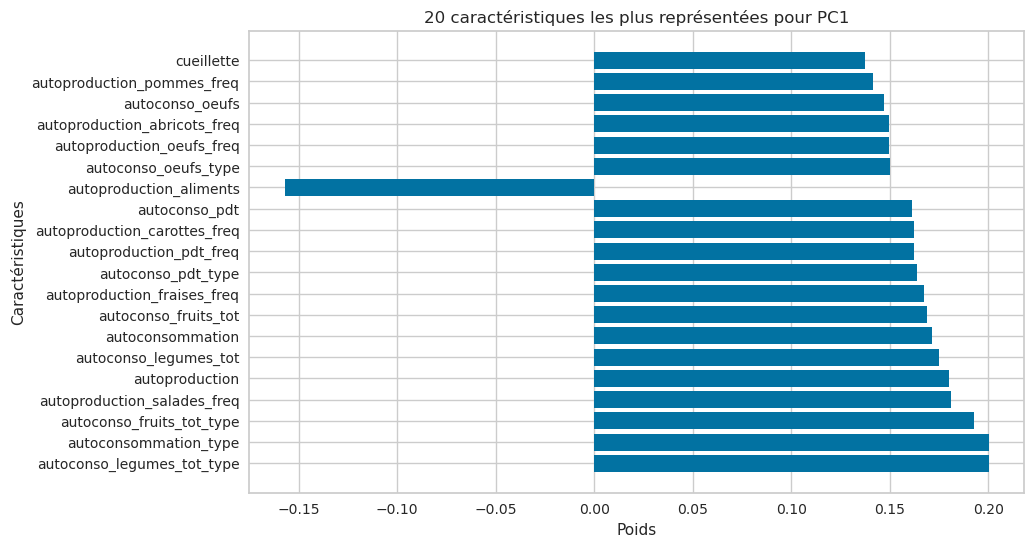

In [13]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC1
pc1_top_features_abs = pca_components.iloc[0].abs().nlargest(20, keep='all')
pc1_top_features = pca_components.iloc[0].loc[pc1_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

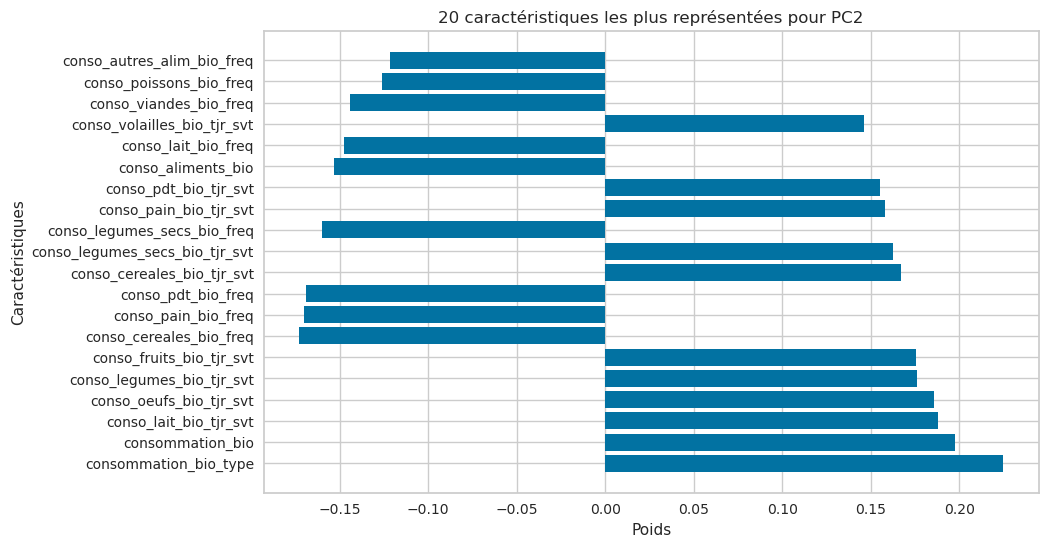

In [14]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC2
pc2_top_features_abs = pca_components.iloc[1].abs().nlargest(20, keep='all')
pc2_top_features = pca_components.iloc[1].loc[pc2_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC2
plt.figure(figsize=(10, 6))
plt.barh(pc2_top_features.index, pc2_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC2')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

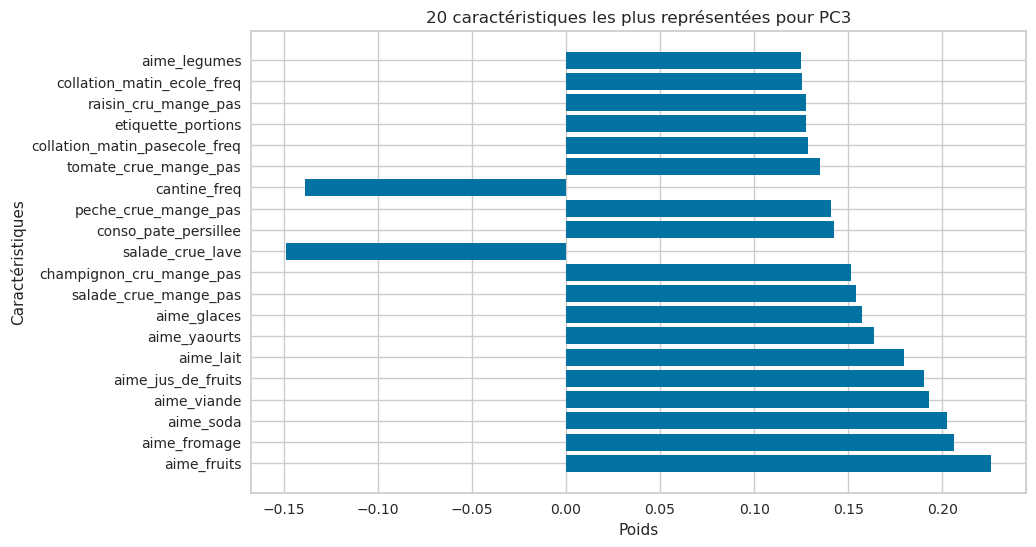

In [15]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC3
pc3_top_features_abs = pca_components.iloc[2].abs().nlargest(20, keep='all')
pc3_top_features = pca_components.iloc[2].loc[pc3_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC3
plt.figure(figsize=(10, 6))
plt.barh(pc3_top_features.index, pc3_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC3')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

#### Clusters K-Means

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

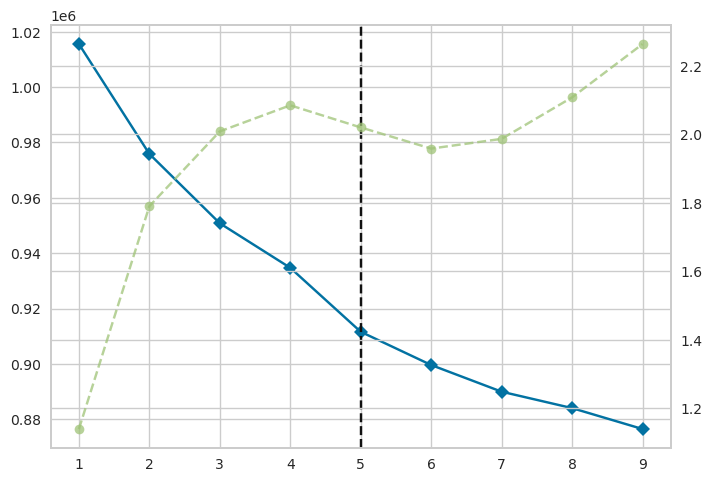

In [16]:
elbow_method = KElbowVisualizer(KMeans(), k=(1,10))
elbow_method.fit(habitudes_indiv_for_clustering_array)

In [17]:
# Effectuer le clustering par K-moyennes
k = 4  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(habitudes_indiv_for_clustering_array)

pca_df['Cluster'] = clusters

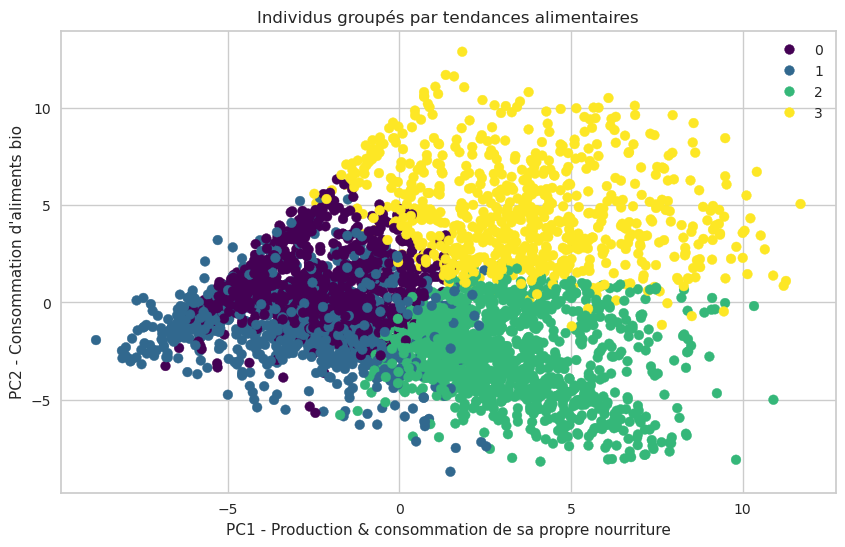

In [18]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par tendances alimentaires')
plt.xlabel('PC1 - Production & consommation de sa propre nourriture')
plt.ylabel('PC2 - Consommation d\'aliments bio')
# plt.zlabel('PC3 - Goûts alimentaires')
plt.show()

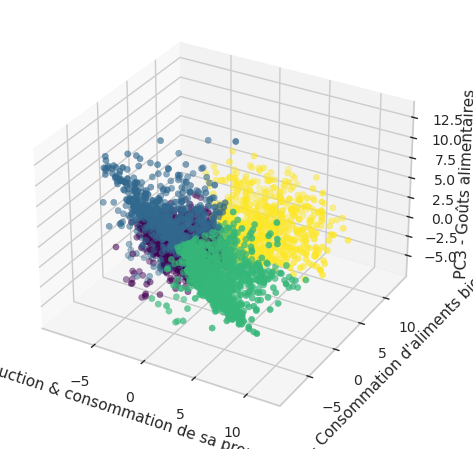

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

ax.set_xlabel('PC1 - Production & consommation de sa propre nourriture')
ax.set_ylabel('PC2 - Consommation d\'aliments bio')
ax.set_zlabel('PC3 - Goûts alimentaires')

plt.show()

#### Clusters CAH

In [20]:
# Utiliser la méthode linkage pour effectuer le clustering hiérarchique
cah = linkage(habitudes_indiv_for_clustering_array, method='ward')

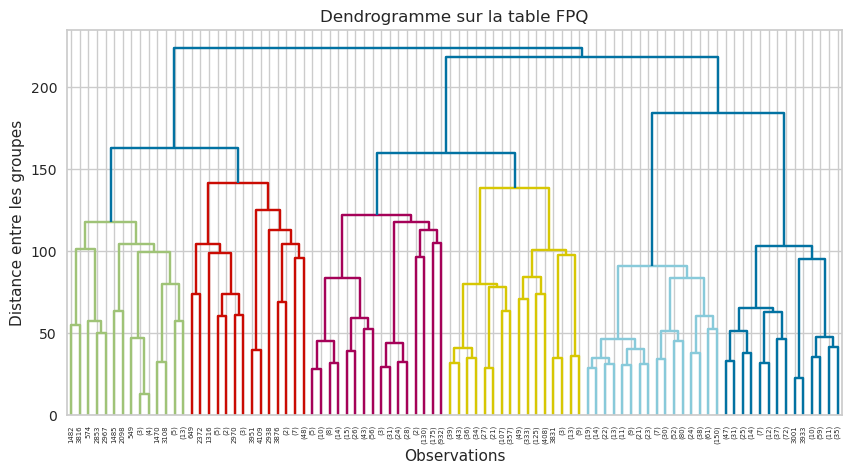

In [21]:
profondeur_dendrogramme_a_afficher = 6

# Afficher le dendrogramme
plt.figure(figsize=(10, 5))
dendrogram(cah,
           truncate_mode='level',
           p=profondeur_dendrogramme_a_afficher)
plt.title("Dendrogramme sur la table FPQ")
plt.xlabel("Observations")
plt.ylabel("Distance entre les groupes")
plt.show()

In [22]:
# Effectuer le clustering par CAH
k = 3  # Nombre de clusters souhaité
clusters = fcluster(cah, k, criterion='maxclust')

pca_df['Cluster'] = clusters

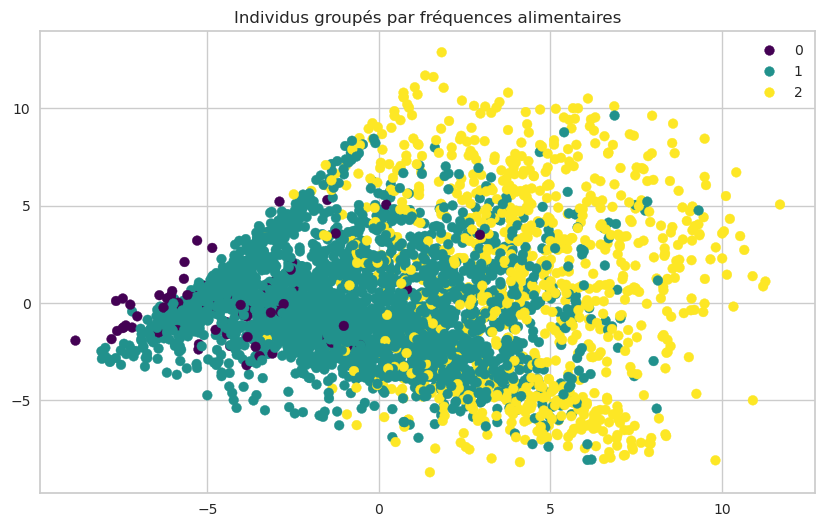

In [23]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par fréquences alimentaires')
# plt.xlabel('PC1 - Consommation de tomates (et autres fruits & légumes)')
# plt.ylabel('PC2 - Consommation d\'agrumes et autres fruits (ex: pomme)')
# plt.zlabel('PC3 - Consommation de soda et junk food')
plt.show()

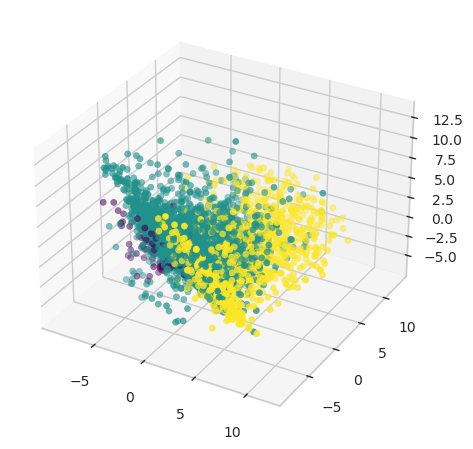

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

# ax.set_xlabel('Consommation de tomates (et autres fruits & légumes)')
# ax.set_ylabel('Consommation d\'agrumes et autres fruits (ex: pomme)')
# ax.set_zlabel('PC3 - Consommation de soda et junk food')

plt.show()

### Clustering sur l'activité physique

#### Preprocessing

In [25]:
actphys_sedent.shape

(4725, 93)

In [26]:
# Sélectionner les caractéristiques pour le clustering
actphys_sedent_for_clustering = actphys_sedent.drop(
    ['POPULATION', 'NOIND'],
    axis=1
).dropna(
    axis=1, how='all'
).select_dtypes(
    include=np.number
)
actphys_sedent_for_clustering.shape

(4725, 91)

In [27]:
# Gérer les valeurs manquantes (NaN)
imputer = SimpleImputer(strategy='most_frequent')
actphys_sedent_for_clustering_array = imputer.fit_transform(actphys_sedent_for_clustering)

In [28]:
# Normaliser les colonnes
scaler = StandardScaler()
actphys_sedent_for_clustering_array = scaler.fit_transform(actphys_sedent_for_clustering_array)

In [29]:
# Détecter et retirer les outliers
outlier_detector = IsolationForest(contamination=0.05, random_state=0)
outlier_labels = outlier_detector.fit_predict(actphys_sedent_for_clustering_array)
actphys_sedent_for_clustering_array = actphys_sedent_for_clustering_array[outlier_labels == 1]
actphys_sedent_for_clustering_array.shape

(4488, 91)

#### ACP

In [30]:
# Effectuer l'ACP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(actphys_sedent_for_clustering_array)

# Obtenir les poids des caractéristiques pour chaque composante principale
pca_components = pd.DataFrame(pca.components_, columns=actphys_sedent_for_clustering.columns)

In [31]:
# Créer un dataframe pour les résultats de l'ACP
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

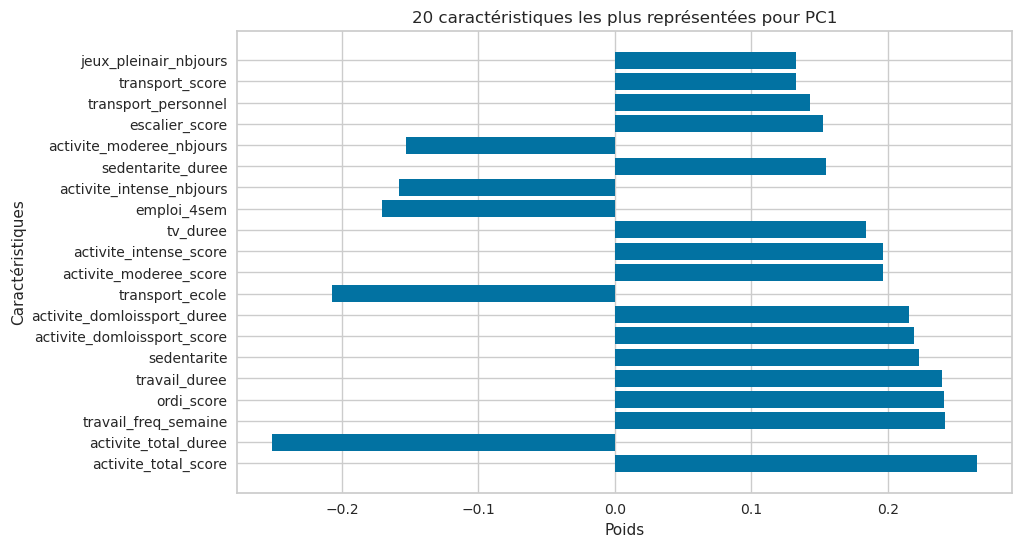

In [32]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC1
pc1_top_features_abs = pca_components.iloc[0].abs().nlargest(20, keep='all')
pc1_top_features = pca_components.iloc[0].loc[pc1_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

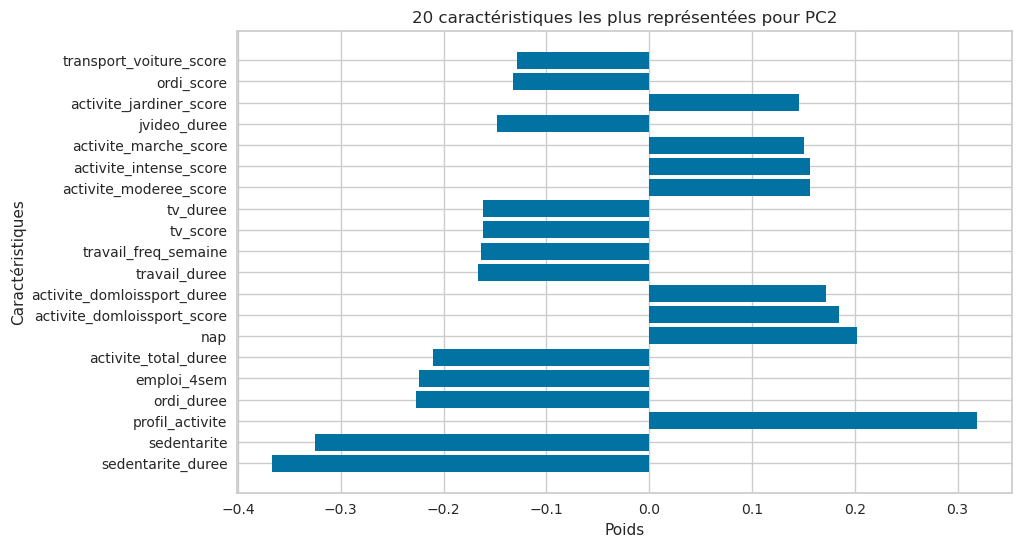

In [33]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC2
pc2_top_features_abs = pca_components.iloc[1].abs().nlargest(20, keep='all')
pc2_top_features = pca_components.iloc[1].loc[pc2_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC2
plt.figure(figsize=(10, 6))
plt.barh(pc2_top_features.index, pc2_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC2')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

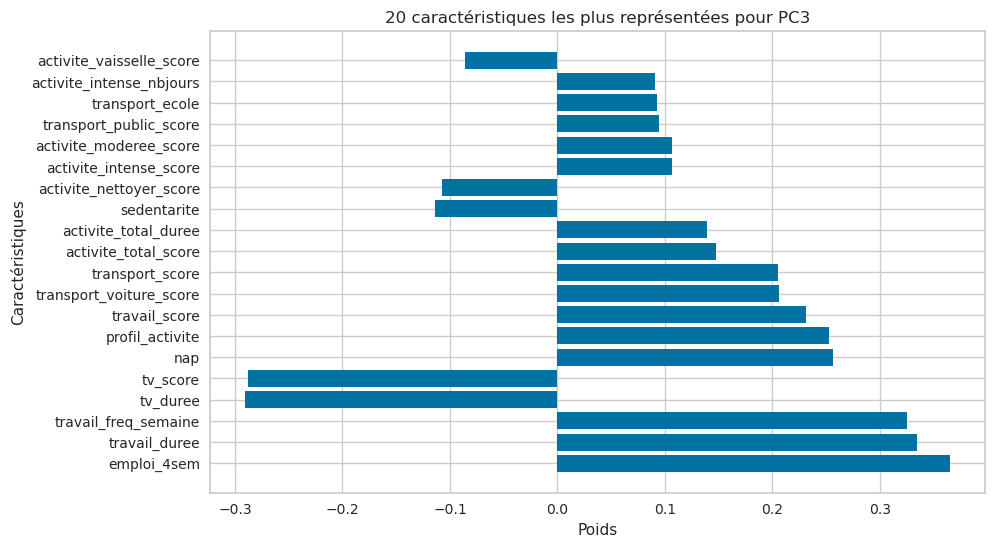

In [34]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC3
pc3_top_features_abs = pca_components.iloc[2].abs().nlargest(20, keep='all')
pc3_top_features = pca_components.iloc[2].loc[pc3_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC3
plt.figure(figsize=(10, 6))
plt.barh(pc3_top_features.index, pc3_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC3')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

#### Clusters K-Means

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

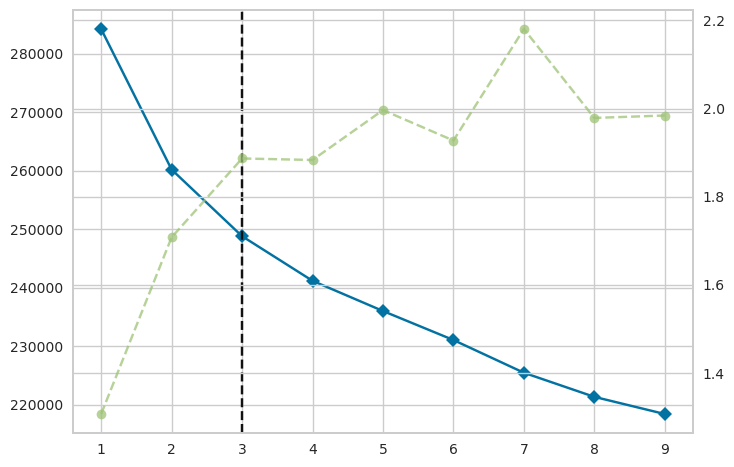

In [35]:
elbow_method = KElbowVisualizer(KMeans(), k=(1,10))
elbow_method.fit(actphys_sedent_for_clustering_array)

In [36]:
# Effectuer le clustering par K-moyennes
k = 2  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(actphys_sedent_for_clustering_array)

pca_df['Cluster'] = clusters

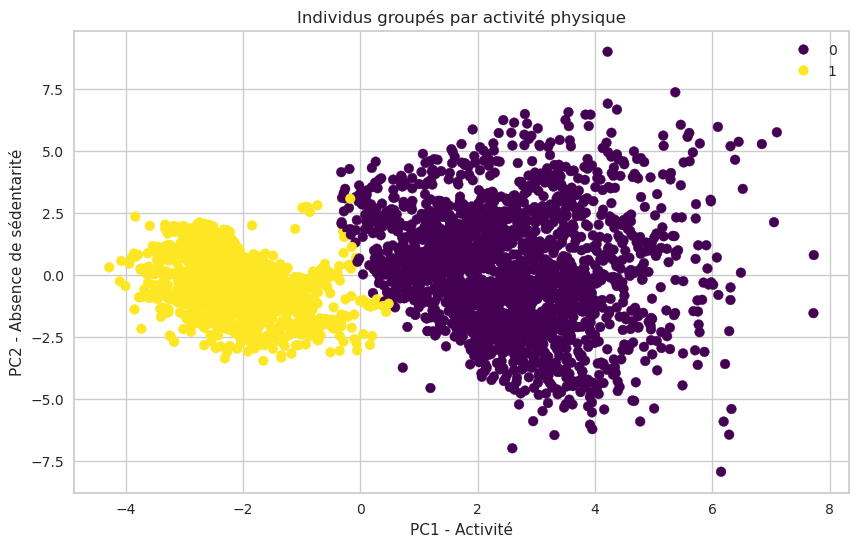

In [37]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par activité physique')
plt.xlabel('PC1 - Activité')
plt.ylabel('PC2 - Absence de sédentarité')
# plt.zlabel('PC3 - Temps passé assis')
plt.show()

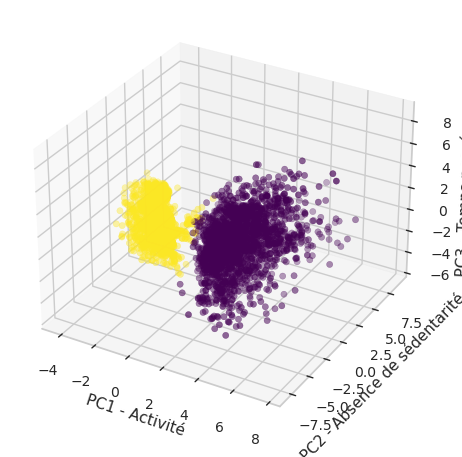

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

ax.set_xlabel('PC1 - Activité')
ax.set_ylabel('PC2 - Absence de sédentarité')
ax.set_zlabel('PC3 - Temps passé assis')

plt.show()

#### Clusters CAH

In [39]:
# Utiliser la méthode linkage pour effectuer le clustering hiérarchique
cah = linkage(actphys_sedent_for_clustering_array, method='ward')

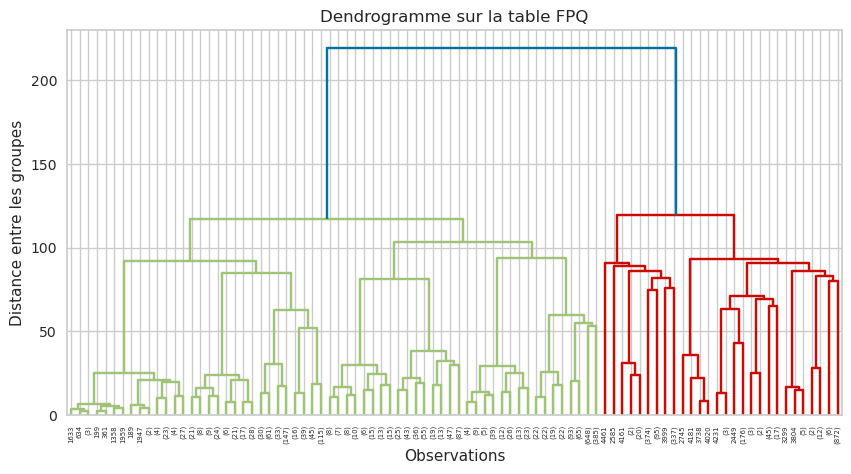

In [40]:
profondeur_dendrogramme_a_afficher = 6

# Afficher le dendrogramme
plt.figure(figsize=(10, 5))
dendrogram(cah,
           truncate_mode='level',
           p=profondeur_dendrogramme_a_afficher)
plt.title("Dendrogramme sur la table FPQ")
plt.xlabel("Observations")
plt.ylabel("Distance entre les groupes")
plt.show()

In [41]:
# Effectuer le clustering par CAH
k = 2  # Nombre de clusters souhaité
clusters = fcluster(cah, k, criterion='maxclust')

pca_df['Cluster'] = clusters

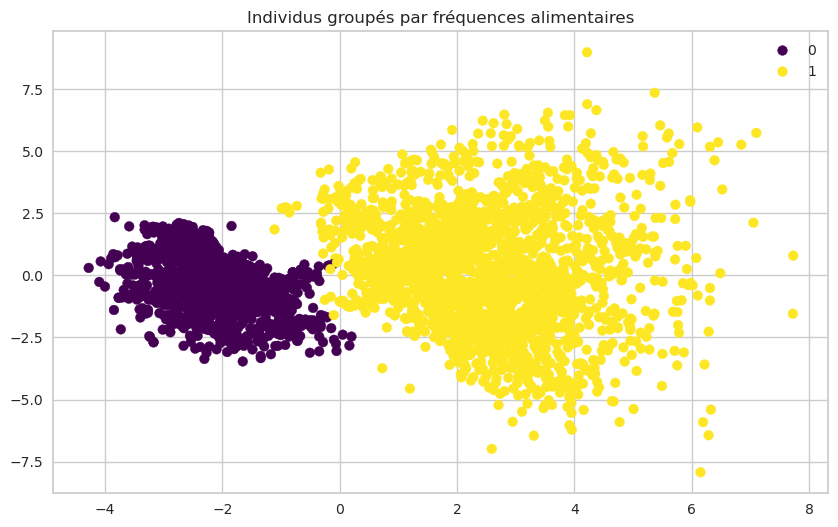

In [42]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par fréquences alimentaires')
# plt.xlabel('PC1 - Consommation de tomates (et autres fruits & légumes)')
# plt.ylabel('PC2 - Consommation d\'agrumes et autres fruits (ex: pomme)')
# plt.zlabel('PC3 - Consommation de soda et junk food')
plt.show()

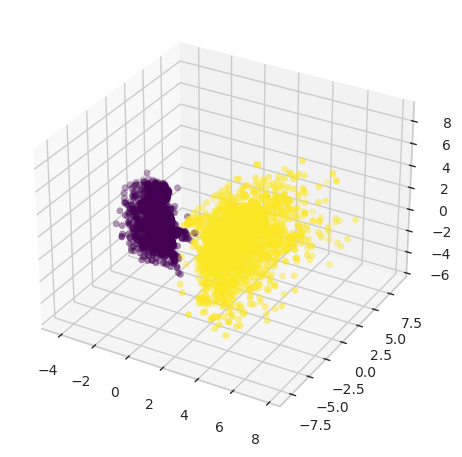

In [43]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

# ax.set_xlabel('Consommation de tomates (et autres fruits & légumes)')
# ax.set_ylabel('Consommation d\'agrumes et autres fruits (ex: pomme)')
# ax.set_zlabel('PC3 - Consommation de soda et junk food')

plt.show()

### Clustering fréquentiel alimentaire

#### Preprocessing

In [44]:
fpq.shape

(4339, 384)

In [45]:
# Sélectionner les caractéristiques pour le clustering
fpq_for_clustering = fpq.drop(
    ['POPULATION', 'NOIND'],
    axis=1
).dropna(
    axis=1, how='all'
).select_dtypes(
    include=np.number
)
fpq_for_clustering.shape

(4339, 382)

In [46]:
# Gérer les valeurs manquantes (NaN)
imputer = SimpleImputer(strategy='most_frequent')
fpq_for_clustering_array = imputer.fit_transform(fpq_for_clustering)

In [47]:
# Normaliser les colonnes
scaler = StandardScaler()
fpq_for_clustering_array = scaler.fit_transform(fpq_for_clustering_array)

In [48]:
# Détecter et retirer les outliers
outlier_detector = IsolationForest(contamination=0.05, random_state=0)
outlier_labels = outlier_detector.fit_predict(fpq_for_clustering_array)
fpq_for_clustering_array = fpq_for_clustering_array[outlier_labels == 1]
fpq_for_clustering_array.shape

(4122, 382)

#### ACP

In [49]:
# Effectuer l'ACP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(fpq_for_clustering_array)

# Obtenir les poids des caractéristiques pour chaque composante principale
pca_components = pd.DataFrame(pca.components_, columns=fpq_for_clustering.columns)

In [50]:
# Créer un dataframe pour les résultats de l'ACP
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

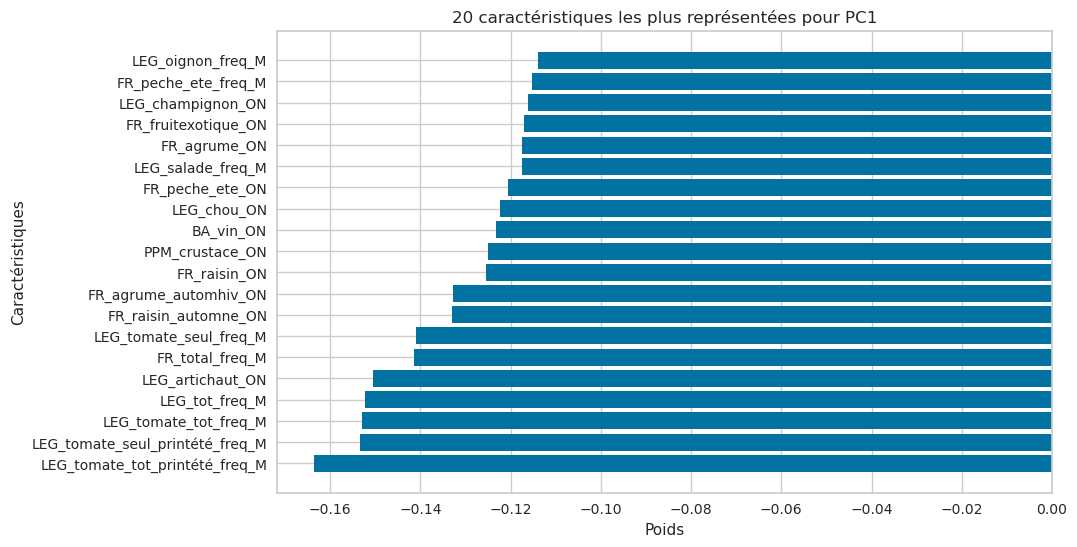

In [51]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC1
pc1_top_features_abs = pca_components.iloc[0].abs().nlargest(20, keep='all')
pc1_top_features = pca_components.iloc[0].loc[pc1_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

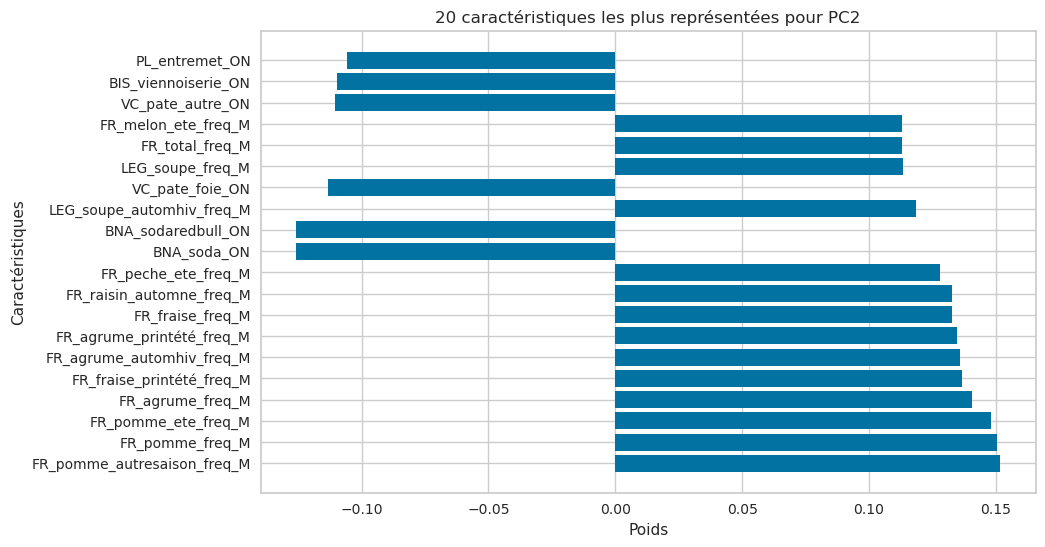

In [52]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC2
pc2_top_features_abs = pca_components.iloc[1].abs().nlargest(20, keep='all')
pc2_top_features = pca_components.iloc[1].loc[pc2_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC2
plt.figure(figsize=(10, 6))
plt.barh(pc2_top_features.index, pc2_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC2')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

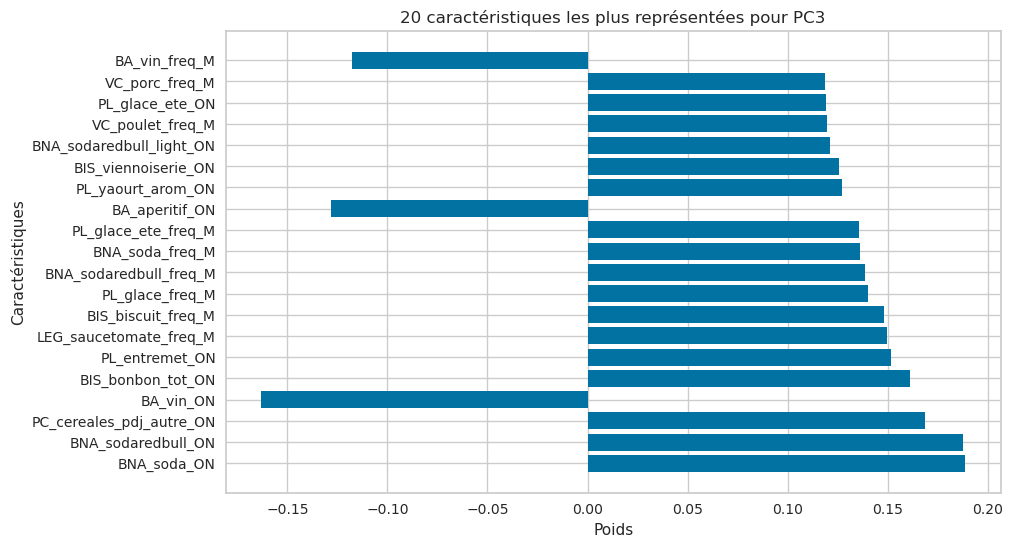

In [53]:
# Sélectionner les 20 caractéristiques les plus représentées pour PC3
pc3_top_features_abs = pca_components.iloc[2].abs().nlargest(20, keep='all')
pc3_top_features = pca_components.iloc[2].loc[pc3_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC3
plt.figure(figsize=(10, 6))
plt.barh(pc3_top_features.index, pc3_top_features.values)
plt.title('20 caractéristiques les plus représentées pour PC3')
plt.xlabel('Poids')
plt.ylabel('Caractéristiques')
plt.show()

#### Clusters K-Means

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

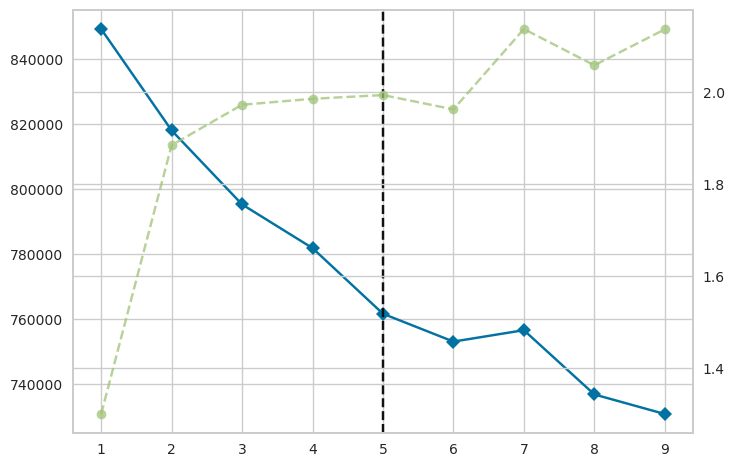

In [54]:
elbow_method = KElbowVisualizer(KMeans(), k=(1,10))
elbow_method.fit(fpq_for_clustering_array)

In [55]:
# Effectuer le clustering par K-moyennes
k = 4  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(fpq_for_clustering_array)

pca_df['Cluster'] = clusters

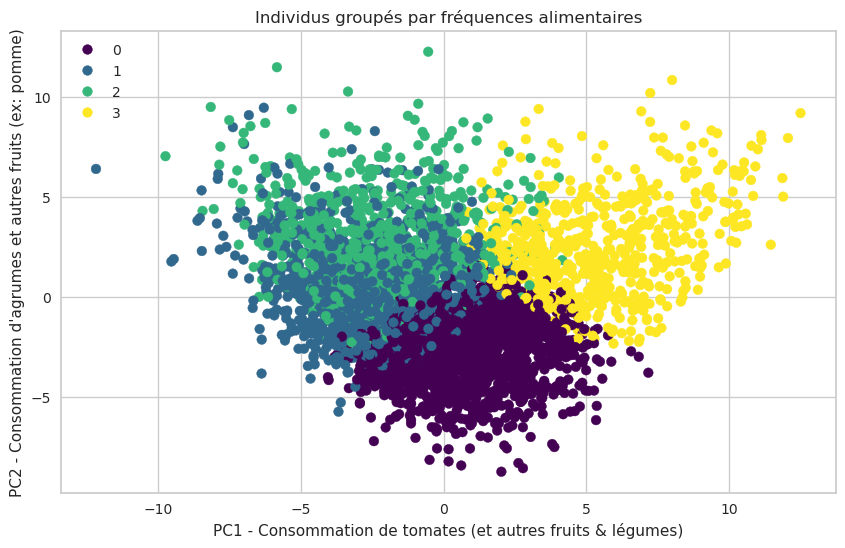

In [56]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par fréquences alimentaires')
plt.xlabel('PC1 - Consommation de tomates (et autres fruits & légumes)')
plt.ylabel('PC2 - Consommation d\'agrumes et autres fruits (ex: pomme)')
# plt.zlabel('PC3 - Consommation de soda et junk food')
plt.show()

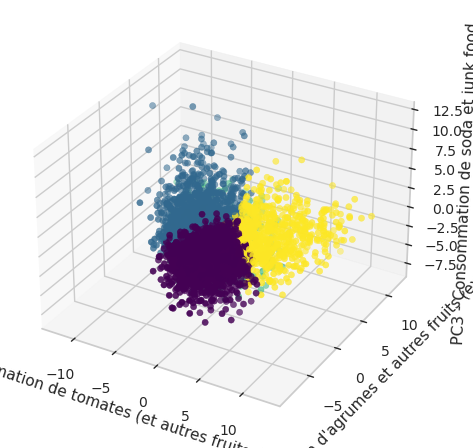

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

ax.set_xlabel('Consommation de tomates (et autres fruits & légumes)')
ax.set_ylabel('Consommation d\'agrumes et autres fruits (ex: pomme)')
ax.set_zlabel('PC3 - Consommation de soda et junk food')

plt.show()

#### Clusters CAH

In [58]:
# Utiliser la méthode linkage pour effectuer le clustering hiérarchique
cah = linkage(fpq_for_clustering_array, method='ward')

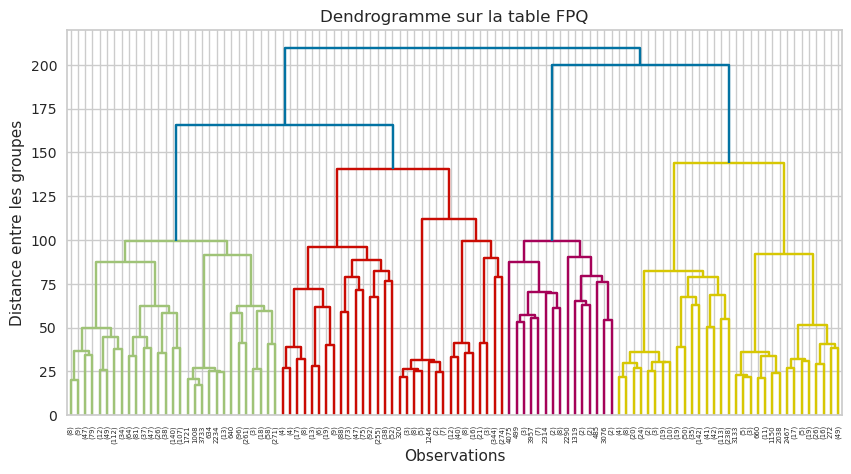

In [59]:
profondeur_dendrogramme_a_afficher = 6

# Afficher le dendrogramme
plt.figure(figsize=(10, 5))
dendrogram(cah,
           truncate_mode='level',
           p=profondeur_dendrogramme_a_afficher)
plt.title("Dendrogramme sur la table FPQ")
plt.xlabel("Observations")
plt.ylabel("Distance entre les groupes")
plt.show()

In [60]:
# Effectuer le clustering par CAH
k = 3  # Nombre de clusters souhaité
clusters = fcluster(cah, k, criterion='maxclust')

pca_df['Cluster'] = clusters

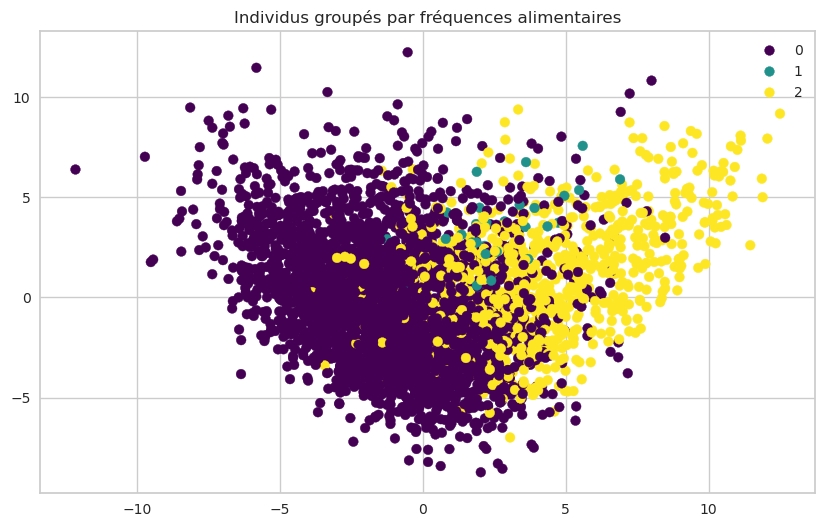

In [61]:
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
# scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k))
plt.title('Individus groupés par fréquences alimentaires')
# plt.xlabel('PC1 - Consommation de tomates (et autres fruits & légumes)')
# plt.ylabel('PC2 - Consommation d\'agrumes et autres fruits (ex: pomme)')
# plt.zlabel('PC3 - Consommation de soda et junk food')
plt.show()

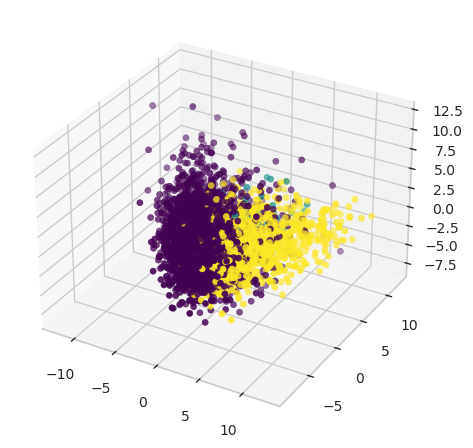

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = pca_df['PC1']
ys = pca_df['PC2']
zs = pca_df['PC3']
ax.scatter(xs, ys, zs, c=pca_df['Cluster'], cmap='viridis')

# ax.set_xlabel('Consommation de tomates (et autres fruits & légumes)')
# ax.set_ylabel('Consommation d\'agrumes et autres fruits (ex: pomme)')
# ax.set_zlabel('PC3 - Consommation de soda et junk food')

plt.show()

### Autres analyses